# Prediction of diabetic progression using Multivariate Regression, Non-Parametric Models and Cross-Validation

The model is trained on scikit learn's toy dataset for diabetes progression. Based on the data recorded from each patient and the actual diabetes level recorded for the same patients after a year from baseline, the model can be used to predict and verify the model accuracy. We are going to split the data into training data, validation data and test data for the purpose.

In [95]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

### 1. LOADING THE DATASET

The values in the dataset have been scaled by standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1) and mean centered. To understand the data better, we're going to explore on non-scaled data by setting scaled=False and then train on the scaled data.

In [96]:
diabetes_ds = datasets.load_diabetes(return_X_y=False, as_frame=False, scaled=False)
X = diabetes_ds.data[:,[2,9]] # using all of the features
y = diabetes_ds.target

The dataset consists records of 442 patients. 

The 'data' in the dataset consists of entries of the following columns -

1. age 
2. sex
3. bmi
4. bp
5. s1(tc) total serum cholesterol
6. s2 (ldl) low-density lipoproteins
7. s3(hdl) high-density lipoproteins
8. s4(tch) total cholesterol / HDL
9. s5(ltg) possibly log of serum triglycerides level
10. s6(glu) blood sugar level

The 'target' data has the record of diabetes progressed in the patients after a year.

#### Sample rows of both the dataset and target diabetes progression result

In [97]:
patients_df = pd.DataFrame(diabetes_ds.data, columns=diabetes_ds.feature_names)
patients_df.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


In [98]:
target_df = pd.DataFrame(diabetes_ds.target)
target_df.head(5)

,0
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


The model we're going to run will have patient BMI in X axis and the predicted diabetes result in Y axis. We are going to run polynomial regressions with all apt features and perform *cross_validation* to find the optimal degree of a polynomial for a regression, preventing overfitting.

To do this, we will first perform analysis of the data by exploring statistics with histogram and correlation matrix.

### 3. EXPLORATORY DATA ANALYSIS

In [99]:
patients_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


From the description of the dataset, we can infer that the patients were between the age 19 and 79 and the BMI range lies between 18 and 42. So the data does not concentrate on a specific group of age group or sex or bmi. With the varying data source, we can train a good prediction model. The data already shows **s6** glucose level of patients where the maximum was only 124. So the data source is a group of people with normal glucose range in the beginning which makes it fit to predict the progression.

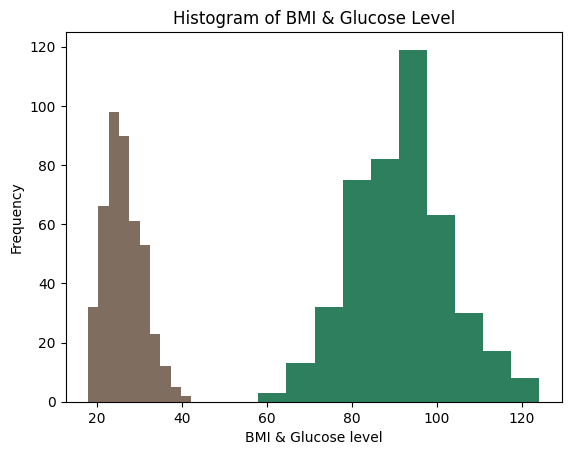

In [118]:
plt.hist(X[:,0], color="#7f6d5f")
plt.hist(X[:,1], color="#2d7f5e")
plt.xlabel('BMI & Glucose level')
plt.ylabel('Frequency')
plt.title('Histogram of BMI & Glucose Level')
plt.show()

According to the histogram that shows frequency of BMI in the given dataset, majority of the patients had BMI within the range of 21 to 32. Only above 50 people had BMI around 20. The number of people with BMI greater than 32 were collectively around 35. From the histogram of glucose level, 90 to 100 seems to be the normal range and only about 10 people have had glucose level around 120.

In [102]:
correlation_matrix = patients_df.corr()
correlation_matrix.head(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000


The correlation matrix shows the relationship of each column with other columns in the dataset. The related columns involved in this prediction model is the bmi and glucose level. Even though the value is small, it shows a positive correlation of 0.388680. Which means as bmi goes higher, elevated glucose level is observed.

### 4. SPLIT TEST DATA

In [103]:
# Check if the data needs cleaning
missing_values = patients_df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


There are no missing values in the dataset and needs no cleaning. We'll move on to splitting the training data and testing the model.

In [104]:
# Split the dataset into 80% train and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Result array
results = []

#### Create the following models and perform cross validation:

2 polynomial regression (we've considering degree 5 and degree 7)

2 decision tree (we're considering max_depth 3 and 5)

2 KNNs (we're considering n_neighbors 2 and 7)

For understandability, splitting the models fit into separate loops.

In [105]:
# Initialize polynomial models
poly_models = [
    ('Polynomial Regression (degree=5)', PolynomialFeatures(degree=5), LinearRegression()),
    ('Polynomial Regression (degree=7)', PolynomialFeatures(degree=7), LinearRegression())
]

# Fit polynomial models
for name, features, model in poly_models:
    train_poly = features.fit_transform(X_train_scaled)
    model.fit(train_poly, y_train)
    cv_scores = cross_validate(model, train_poly, y_train, scoring=('r2', 'neg_mean_absolute_error'), cv=5)
    results.append({
        'Model': name,
        'Model Instance': model,
        'R-Squared Mean': np.mean(cv_scores['test_r2']),
        'R-Squared Std': np.std(cv_scores['test_r2']),
        'MAE-Mean': -np.mean(cv_scores['test_neg_mean_absolute_error']),
        'MAE-Std': np.std(cv_scores['test_neg_mean_absolute_error'])
    })

In [106]:
tree_models = [
    ('Decision Tree (max_depth=3)', DecisionTreeRegressor(max_depth=3)),
    ('Decision Tree (max_depth=5)', DecisionTreeRegressor(max_depth=5)),
]

for name, model in tree_models:
    model.fit(X_train_scaled, y_train)
    cv_scores = cross_validate(model, X_train_scaled, y_train, scoring=('r2', 'neg_mean_absolute_error'), cv=5)
    results.append({
        'Model': name,
        'Model Instance': model,
        'R-Squared Mean': np.mean(cv_scores['test_r2']),
        'R-Squared Std': np.std(cv_scores['test_r2']),
        'MAE-Mean': -np.mean(cv_scores['test_neg_mean_absolute_error']),
        'MAE-Std': np.std(cv_scores['test_neg_mean_absolute_error'])
    })

In [107]:
knn_models = [
    ('kNN (n_neighbors=2)', KNeighborsRegressor(n_neighbors=2)),
    ('kNN (n_neighbors=7)', KNeighborsRegressor(n_neighbors=7))
]

for name, model in knn_models:
    model.fit(X_train_scaled, y_train)
    cv_scores = cross_validate(model, X_train_scaled, y_train, scoring=('r2', 'neg_mean_absolute_error'), cv=5)
    results.append({
        'Model': name,
        'Model Instance': model,
        'R-Squared Mean': np.mean(cv_scores['test_r2']),
        'R-Squared Std': np.std(cv_scores['test_r2']),
        'MAE-Mean': -np.mean(cv_scores['test_neg_mean_absolute_error']),
        'MAE-Std': np.std(cv_scores['test_neg_mean_absolute_error'])
    })

In [108]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Model Instance,R-Squared Mean,R-Squared Std,Mean,Standard Deviation
0,Polynomial Regression (degree=5),LinearRegression(),0.305176,0.130262,52.557615,3.922580
1,Polynomial Regression (degree=7),LinearRegression(),-4.183237,6.283975,82.395747,36.919165
2,Decision Tree (max_depth=3),DecisionTreeRegressor(max_depth=3),0.297212,0.176811,52.577075,4.490611
3,Decision Tree (max_depth=5),DecisionTreeRegressor(max_depth=5),0.207454,0.217244,54.669997,6.016465
4,kNN (n_neighbors=2),KNeighborsRegressor(n_neighbors=2),0.054517,0.261067,59.081147,8.142837
5,kNN (n_neighbors=7),KNeighborsRegressor(n_neighbors=7),0.249947,0.155471,53.717045,4.213777


In [109]:
best_model = results_df.loc[results_df['R-Squared Mean'].idxmax()]
print("Best Model:")
best_model

Best Model:


Model                 Polynomial Regression (degree=5)
Model Instance                      LinearRegression()
R-Squared Mean                                0.305176
R-Squared Std                                 0.130262
Mean                                         52.557615
Standard Deviation                             3.92258
Name: 0, dtype: object

#### Predict with the best model on the test dataset

In [110]:
# Predict on the test set
pred_test = []
best_model_train = []
if 'Polynomial' in best_model['Model']:
    X_train_transformed = PolynomialFeatures(degree=int(best_model['Model'][-2])).fit_transform(X_train_scaled)
    X_test_transformed = PolynomialFeatures(degree=int(best_model['Model'][-2])).fit_transform(X_test_scaled)
    pred_test = X_test_transformed
    best_model_train = X_train_transformed
else:
    pred_test = X_test_scaled
    best_model_train = X_train_scaled

y_pred = best_model['Model Instance'].predict(pred_test)

#### Test Results:

In [111]:
# Calculate R-Squared, MAE, and MAPE
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [112]:
# Display results
print("\nTest Set Results:")
print(f"R-Squared: {r_squared:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")


Test Set Results:
R-Squared: 0.3271
MAE: 48.7091
MAPE: 42.6173%


#### Graph plot for the fitted model

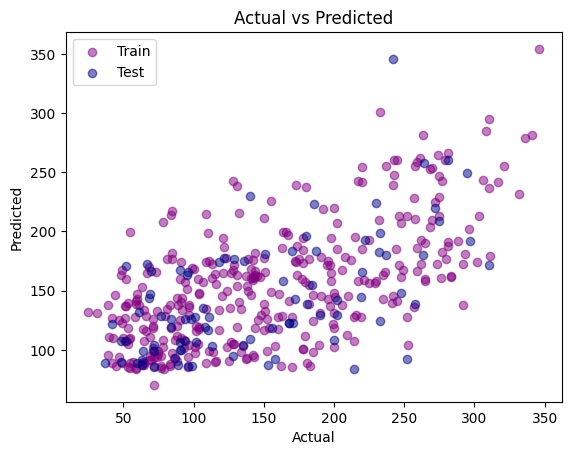

In [115]:
# Plot the data points and the fitted model
plt.scatter(y_train, best_model['Model Instance'].predict(best_model_train), label='Train', color='purple', alpha=0.5)
plt.scatter(y_test, y_pred, label='Test', color='navy', alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

#### Conclusion:

The limitations in the plot of the best model derived from Polynomial regression degree 5 is that it the residuals seem to be high for some points. But there does seem to be a close difference between the actual data points and the predicted ones.

While our models perform well on test data, real-world applicability remains uncertain without regular testing. Hence, despite the promising choice, awareness of limitations persists, urging continuous refinement for reliable predictions. The quest for the best diabetes progression prediction model relies on cross-validation performance. In our case, though decision trees excel at highlighting significant features, polynomial regression has seemed to perform well.